# Using monai

In [24]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.transforms import \
    Compose, LoadNiftid, ScaleIntensityd, AddChanneld, ToTensord, RandSpatialCropd
from monai.data import list_data_collate
from monai.inferers import sliding_window_inference

## Data Collection

In [25]:
data_dir = 'data/'
print(os.listdir(data_dir))

['PSEA12 Baseline', 'PSEA13 PostGel', 'PSEA27 PostGel', 'PSEA25 Baseline', 'PSEA12 PostGel', 'PSEA14 Baseline', 'PSEA14 PostGel', 'PSEA20 PostMI', 'PSEA18 PostMI', 'PSEA12 PostMI', 'PSEA18 Baseline', 'PSEA27 PostMI', 'PSEA13 Baseline', 'PSEA20 PostGel', 'PSEA25 PostMI', 'PSEA27 Baseline', 'PSEA13 PostMI', 'PSEA25 PostGel', 'PSEA18 PostGel']


In [26]:
images = sorted(glob.glob(data_dir + '**/*CTImg*', recursive=True))
masks = sorted(glob.glob(data_dir + '**/*Mask*', recursive=True))
data_dicts = [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(images, masks)]

In [27]:
def select_animals(images, masks, animals):
    """Returns the images and masks as a dictionary for specific animals."""
    filtered_images = []
    filtered_masks = []
    for animal in animals:
        filtered_images.extend(filter(lambda x: 'PSEA' + str(animal) in x, images))
        filtered_masks.extend(filter(lambda x: 'PSEA' + str(animal) in x, masks))
    return [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(filtered_images, filtered_masks)]

### Data Transforms


In [28]:
data_keys = ['image', 'mask']
data_transforms = Compose([
    LoadNiftid(keys=data_keys),
    ScaleIntensityd(keys=data_keys),
    AddChanneld(keys=data_keys),
    RandSpatialCropd(
        keys=data_keys,
        roi_size=(128, 128, 1),
        random_size=False
    ),
    ToTensord(keys=data_keys)
])

train_transforms = Compose([
    data_transforms
])

val_transforms = Compose([
    data_transforms
])

test_transforms = Compose([
    data_transforms
])

In [29]:
check_ds = monai.data.Dataset(data=data_dicts, transform=data_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

In [30]:
check_data['image'].shape

torch.Size([1, 1, 128, 128, 1])

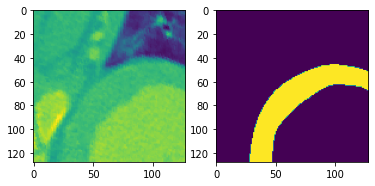

In [31]:
plt.figure('check')
plt.subplot(1, 2, 1)
plt.imshow(check_data['image'][0][0][:, :, 0])
plt.subplot(1, 2, 2)
plt.imshow(check_data['mask'][0][0][:, :, 0])

In [32]:
train_dicts = select_animals(images, masks, [12, 13, 14, 18, 20])
val_dicts = select_animals(images, masks, [25])
test_dicts = select_animals(images, masks, [27])

### Datasets and Loaders

In [33]:
train_ds = monai.data.CacheDataset(
    data=train_dicts,
    transform=train_transforms,
    cache_rate=1.0
)
train_patched_ds = monai.data.GridPatchDataset(train_ds, PATCH_SIZE)
train_loader = DataLoader(
#     train_patched_ds,
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Load and cache transformed data...
114/114 [==============================]  


In [34]:
val_ds = monai.data.CacheDataset(
    data=val_dicts,
    transform=val_transforms,
    cache_rate=1.0
)
val_loader = DataLoader(
    val_ds,
    batch_size=1
)

Load and cache transformed data...
30/30 [==============================]  


In [35]:
test_ds = monai.data.CacheDataset(
    data=test_dicts,
    transform=test_transforms,
    cache_rate=1.0
)
test_loader = DataLoader(
    test_ds,
    batch_size=1
)

Load and cache transformed data...
30/30 [==============================]  


In [36]:
data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

## Model Training

### Hyperparameters

In [37]:
PATCH_SIZE = (64, 64, 1)
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
NUM_EPOCHS = 4000

### Model, Loss, Optimizer

In [38]:
device = torch.device('cuda:0')
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 258, 512, 1024),
    strides=(2, 2, 2, 2),
    norm=monai.networks.layers.Norm.BATCH
).to(device)
criterion = monai.losses.DiceLoss(to_onehot_y=True, do_softmax=True)
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)

### Training Loop

In [23]:
writer = SummaryWriter()
VAL_INTERVAL = 5
epoch_loss_values = []
metric_values = []

best_metric_epoch = -1

phase = 'val'
epoch = 0
while epoch < NUM_EPOCHS:
    if epoch % VAL_INTERVAL == 0 and phase == 'train':
        epoch -= 1
        phase = 'val'
        print('-' * 10)
        print('Validation')
    
    else:
        phase = 'train'
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        lr = get_lr(optimizer)
        print('Learning Rate: ', lr)
        writer.add_scalar('learning_rate', lr, epoch + 1)

    if phase == 'train':
        model.train()
    else:
        model.eval()
        
    epoch_loss = 0
    step = 0
    for batch_data in data_loaders[phase]:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['mask'].to(device)
        inputs = inputs.squeeze(4)
        labels = labels.squeeze(4)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
        
        epoch_loss += loss.item()
    epoch_loss /= step
    
    if phase == 'train':
        epoch_loss_values.append(epoch_loss)
        print('epoch {} average loss: {:.4f}'.format(epoch + 1, epoch_loss))
    
    else:
        metric_values.append(epoch_loss)
        best_metric = min(metric_values)
        if epoch_loss <= best_metric:
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_metric_model.pth')
            print('Saved new best metric model')
        print('val average loss: {:.4f}'.format(epoch_loss))
        print('best val loss: {:.4f} at epoch {}'.format(best_metric, best_metric_epoch))
    
    writer.add_scalar('loss/' + phase, epoch_loss, epoch + 1)
    epoch += 1

----------
Epoch 1/4000
Learning Rate:  0.0001


AttributeError: 'str' object has no attribute 'shape'

## Evaluating the Model

In [3]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
with torch.no_grad():
    for i, test_data in enumerate(data_loaders['val']):
        if i > 5:
            break
        
        roi_size = (64, 64, 1)
        sw_batch_size = 4
#         output = sliding_window_inference(
#             test_data['image'].to(device),
#             roi_size,
#             sw_batch_size,
#             model
#         ),
        output = model(test_data['image'].to(device).squeeze(4))
        print(output.shape)
        plt.figure('check')
        plt.subplot(1, 3, 1)
        plt.title('Image ' + str(i))
        plt.imshow(test_data['image'][0, 0, :, :, 0], cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title('Mask ' + str(i))
        plt.imshow(test_data['mask'][0, 0, :, :, 0])
        plt.subplot(1, 3, 3)
        plt.title('Output ' + str(i))
        output = torch.argmax(output, dim=1).detach().cpu()[0, :, :]
        print(output.shape)
        plt.imshow(output)
        plt.show()



NameError: name 'model' is not defined

## Model training with scheduler

In [25]:
PATCH_SIZE = (64, 64, 1)
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 4000

In [26]:
device = torch.device('cuda:0')
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 258, 512, 1024),
    strides=(2, 2, 2, 2),
    norm=monai.networks.layers.Norm.BATCH
).to(device)
criterion = monai.losses.DiceLoss(to_onehot_y=True, do_softmax=True)
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [28]:
writer = SummaryWriter()
VAL_INTERVAL = 5
epoch_loss_values = []
metric_values = []

best_metric_epoch = -1

phase = 'val'
epoch = 0
while epoch < NUM_EPOCHS:
    if epoch % VAL_INTERVAL == 0 and phase == 'train':
        epoch -= 1
        phase = 'val'
        print('-' * 10)
        print('Validation')
    
    else:
        phase = 'train'
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        lr = get_lr(optimizer)
        print('Learning Rate: ', lr)
        writer.add_scalar('learning_rate', lr, epoch + 1)

    if phase == 'train':
        model.train()
    else:
        model.eval()
        
    epoch_loss = 0
    step = 0
    for batch_data in data_loaders[phase]:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['mask'].to(device)
        inputs = inputs.squeeze(4)
        labels = labels.squeeze(4)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
            else:
                scheduler.step(loss)
        
        epoch_loss += loss.item()
    epoch_loss /= step
    
    if phase == 'train':
        epoch_loss_values.append(epoch_loss)
        print('epoch {} average loss: {:.4f}'.format(epoch + 1, epoch_loss))
    
    else:
        metric_values.append(epoch_loss)
        best_metric = min(metric_values)
        if epoch_loss <= best_metric:
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_metric_model.pth')
            print('Saved new best metric model')
        print('val average loss: {:.4f}'.format(epoch_loss))
        print('best val loss: {:.4f} at epoch {}'.format(best_metric, best_metric_epoch))
    
    writer.add_scalar('loss/' + phase, epoch_loss, epoch + 1)
    epoch += 1

----------
Epoch 1/4000
Learning Rate:  0.001
epoch 1 average loss: 0.6373
----------
Epoch 2/4000
Learning Rate:  0.001
epoch 2 average loss: 0.5874
----------
Epoch 3/4000
Learning Rate:  0.001
epoch 3 average loss: 0.5657
----------
Epoch 4/4000
Learning Rate:  0.001
epoch 4 average loss: 0.5566
----------
Epoch 5/4000
Learning Rate:  0.001
epoch 5 average loss: 0.5482
----------
Validation
Saved new best metric model
val average loss: 0.5519
best val loss: 0.5519 at epoch 5
----------
Epoch 6/4000
Learning Rate:  1e-05
epoch 6 average loss: 0.5439
----------
Epoch 7/4000
Learning Rate:  1e-05
epoch 7 average loss: 0.5452
----------
Epoch 8/4000
Learning Rate:  1e-05
epoch 8 average loss: 0.5496
----------
Epoch 9/4000
Learning Rate:  1e-05
epoch 9 average loss: 0.5519
----------
Epoch 10/4000
Learning Rate:  1e-05
epoch 10 average loss: 0.5449
----------
Validation
Saved new best metric model
val average loss: 0.5212
best val loss: 0.5212 at epoch 10
----------
Epoch 11/4000
Learni

KeyboardInterrupt: 